In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt


Illustrated below we have 4 differernt ways to handle picture analyisis. A time series, where you have perfect resolution on the time, but no resolution on frequency. A fourier in which we have no resolution on time, but perfect knowledge of frequency. A spectogram, which divides a picture into small windows granting some amount of time and frequency information.
And finally the wavelet, think of it as a smarter spectogram, where instead of handling all frequencies equal, the assumption is made that lower frequencies doesnt need as much information regarding time, since this waves tend to longer lived, and as you move up in the frequency domain, you care more and more about the time aspect at the loss of frequency. 
A wavelet is a short-lived oscillation localised in time.

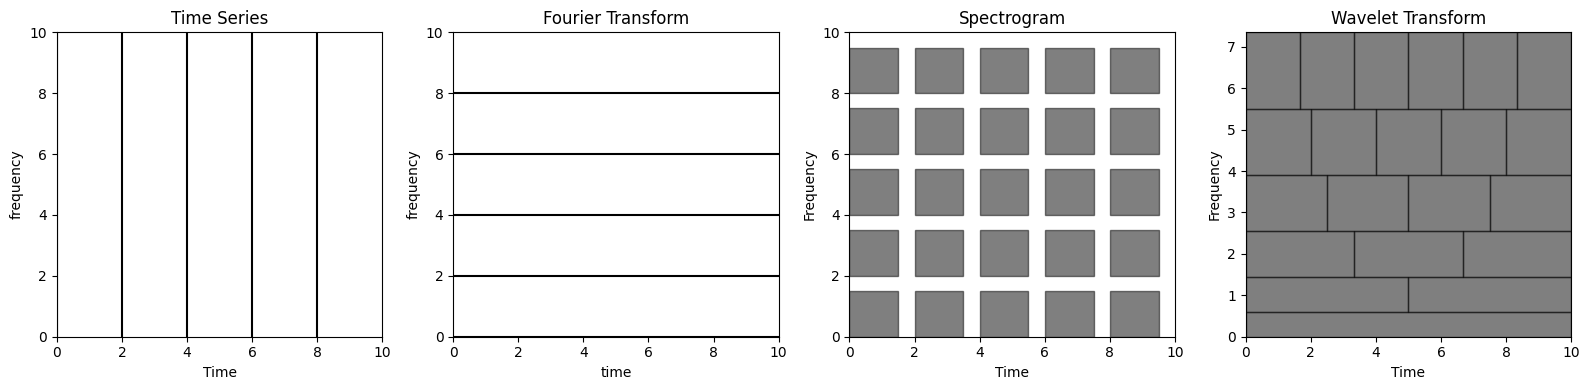

In [2]:
# Generate 4 plots side by side. The plots are to illustrate how different analysis handle resolution, we want a time series, a fourier transform and a spectrogram and a wavelet transform
# We do not want an actual signal, just lines to illustrate the concepts. i.e. vertical lines for time series, horizontal lines for fourier transform, boxes for spectogram, and overlapping boxes for wavelet transform
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
# Time series
axs[0].set_title('Time Series')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('frequency')
for i in range(5):
    axs[0].axvline(x=i*2, color='black')
axs[0].set_xlim(0, 10)
axs[0].set_ylim(0, 10)
# Fourier Transform
axs[1].set_title('Fourier Transform')
axs[1].set_xlabel('time')
axs[1].set_ylabel('frequency')
for i in range(5):
    axs[1].axhline(y=i*2, color='black')
axs[1].set_xlim(0, 10)
axs[1].set_ylim(0, 10)
# Spectrogram
axs[2].set_title('Spectrogram')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Frequency')
for i in range(5):
    for j in range(5):
        rect = plt.Rectangle((i*2, j*2), 1.5, 1.5, color='black', alpha=0.5)
        axs[2].add_patch(rect)
axs[2].set_xlim(0, 10)
axs[2].set_ylim(0, 10)
# Wavelet Transform
axs[3].set_title('Wavelet Transform')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Frequency')

levels = 6
time_max = 10
y = 0   # running vertical position

for level in range(levels):
    num_boxes = level + 1
    width = time_max / num_boxes
    height = 0.6 + 0.25 * level   # taller at higher freq

    for k in range(num_boxes):
        x = k * width
        rect = plt.Rectangle((x, y), width, height, color="black", alpha=0.5)
        axs[3].add_patch(rect)

    # move up exactly by this level's height (no gaps)
    y += height

axs[3].set_xlim(0, 10)
axs[3].set_ylim(0, y)

plt.tight_layout()
plt.show()

Utilizing the Mallats pyramid to downsample.
Using what is know as High pass filters (Mother) & Low pass filters (Father) on a signal.
The result from the LPF results in a approximation(A), whereas the HPF returns a Detail (D).
For the pyramid structure to take shape, you iterate on the approximation with both filters again.

A simple example is the Haar wavelet, here the HPF is the average and the LPF difference.
Suppose a signal  S = [9,7,3,5]
A_1 = [8,4] & D_1 = [1,-1]
A_2 = [6], D_2 = [2]
So the Haar decomposition of our original signal can be written as S = A_2 D_1 D_2 =  [6, 2, 1, -1]




In [ ]:
import ipywidgets as widgets
from IPython.display import display

# 1. Signal Setup
#N = 1024
#t = np.linspace(0, 1, N)
#signal = np.sin(2 * np.pi * 40 * t) 

N = 8
t = np.arange(N)
signal = np.array([0, 2, 4, 6, 6, 4, 2, 0])

# 2. Define UI Elements
level_slider = widgets.IntSlider(min=1, max=10, step=1, value=1, description='Level')
pos_slider = widgets.IntSlider(min=0, max=(N//2)-1, step=1, value=0, description='Position')
filter_type = widgets.Dropdown(options=['Low-pass (Father)', 'High-pass (Mother)'], value='High-pass (Mother)', description='Filter')
wavelet_name = widgets.Dropdown(options=['haar', 'db4', 'sym8'], value='haar', description='Wavelet')

# 3. Link Level to Position Slider Max
def update_pos_max(*args):
    stride = 2**level_slider.value
    new_max = (N // stride) - 1
    pos_slider.max = max(0, new_max)
    # Reset position to 0 if it's out of bounds
    if pos_slider.value > new_max:
        pos_slider.value = 0

level_slider.observe(update_pos_max, 'value')

# 4. The Plotting Function
def plot_inner_product(level, position_index, filter_type, wavelet_name):
    wavelet = pywt.Wavelet(wavelet_name)
    mode = 'a' if filter_type == 'Low-pass (Father)' else 'd'
    wavelet_data = pywt.upcoef(mode, [1.0], wavelet, level=level)
    
    stride = 2**level
    actual_pos = (position_index * stride) + (stride // 2)
    
    filter_size = len(wavelet_data)
    filter_window = np.zeros(N)
    
    start = actual_pos - filter_size // 2
    end = start + filter_size
    
    if start < N and end > 0:
        win_start = max(0, start)
        win_end = min(N, end)
        filt_start = max(0, -start)
        filt_end = filt_start + (win_end - win_start)
        filter_window[win_start:win_end] = wavelet_data[filt_start:filt_end]

    contributions = signal * filter_window
    total_coeff = np.sum(contributions) * (np.sqrt(2)**level)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    ax1.plot(t, signal, 'k', alpha=0.3)
    vis_scale = (2**(level/2)) 
    ax1.plot(t, filter_window * vis_scale, color='blue', lw=1.5)
    ax1.set_title(f"Level {level} | Step {position_index} (Stride {stride})\nNormalized Coeff: {total_coeff:.4f}")
    
    ax2.axhline(0, color='black', lw=1)
    ax2.fill_between(t, contributions * (np.sqrt(2)**level), 0, where=(contributions > 0), color='green', alpha=0.6)
    ax2.fill_between(t, contributions * (np.sqrt(2)**level), 0, where=(contributions < 0), color='red', alpha=0.6)
    
    if N <= 16:
        ax1.set_xlim(-0.5, N - 0.5)
    else:
        zoom_width = (N * 0.1) / (2**(level-1)) if level < 6 else N * 0.5
        ax1.set_xlim(max(0, actual_pos - zoom_width), min(N, actual_pos + zoom_width))
    
    plt.tight_layout()
    plt.show()

# 5. Display UI
ui = widgets.VBox([widgets.HBox([level_slider, pos_slider]), widgets.HBox([filter_type, wavelet_name])])
out = widgets.interactive_output(plot_inner_product, {
    'level': level_slider,
    'position_index': pos_slider,
    'filter_type': filter_type,
    'wavelet_name': wavelet_name
})

display(ui, out)

Output()

The basic idea is to compute how much of a wavelet is in a signal for a particular scale and location. For those familiar with convolutions, that’s exactly what this is. A signal is convolved with a set of wavelets at a variety of scales.

In other words, we pick a wavelet of a particular scale (like the blue wavelet below). Then, we slide this wavelet across the entire signal (i.e. vary its location), where at each time step we multiply the wavelet and signal. The product of this multiplication gives us a coefficient for that wavelet scale at that particular time step. We then increase the wavelet scale (e.g. the red and green wavelets) and repeat the process. https://builtin.com/data-science/wavelet-transform

Original Signal:  [10 10 10 10 10 20 20 20]
Approximation (cA ): [14.14213562 14.14213562 21.21320344 28.28427125]
Detail (cD): [ 0.          0.         -7.07106781  0.        ]


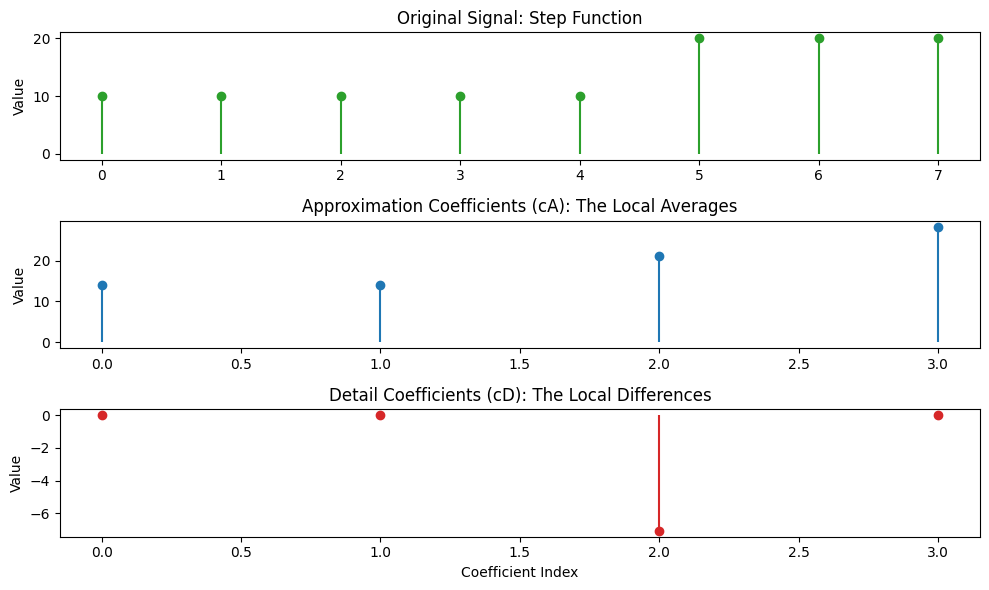

In [3]:
# Our signal: A clear 'step' function
# Imagine this is a sensor reading that suddenly jumps
step_signal = np.array([10, 10, 10, 10, 10, 20, 20, 20])

# Perform 1-level Haar decomposition
cA, cD = pywt.dwt(step_signal, 'haar')

print("Original Signal: ", step_signal)
print("Approximation (cA ):", cA)
print("Detail (cD):", cD)

# Visualization
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6), sharex=False)

ax1.stem(step_signal, linefmt='C2-', markerfmt='C2o', basefmt=" ")
ax1.set_title("Original Signal: Step Function")
ax1.set_ylabel("Value")


ax2.stem(cA, linefmt='C0-', markerfmt='C0o', basefmt=" ")
ax2.set_title("Approximation Coefficients (cA): The Local Averages")
ax2.set_ylabel("Value")

ax3.stem(cD, linefmt='C3-', markerfmt='C3o', basefmt=" ")
ax3.set_title("Detail Coefficients (cD): The Local Differences")
ax3.set_ylabel("Value")
ax3.set_xlabel("Coefficient Index")

plt.tight_layout()
plt.show()

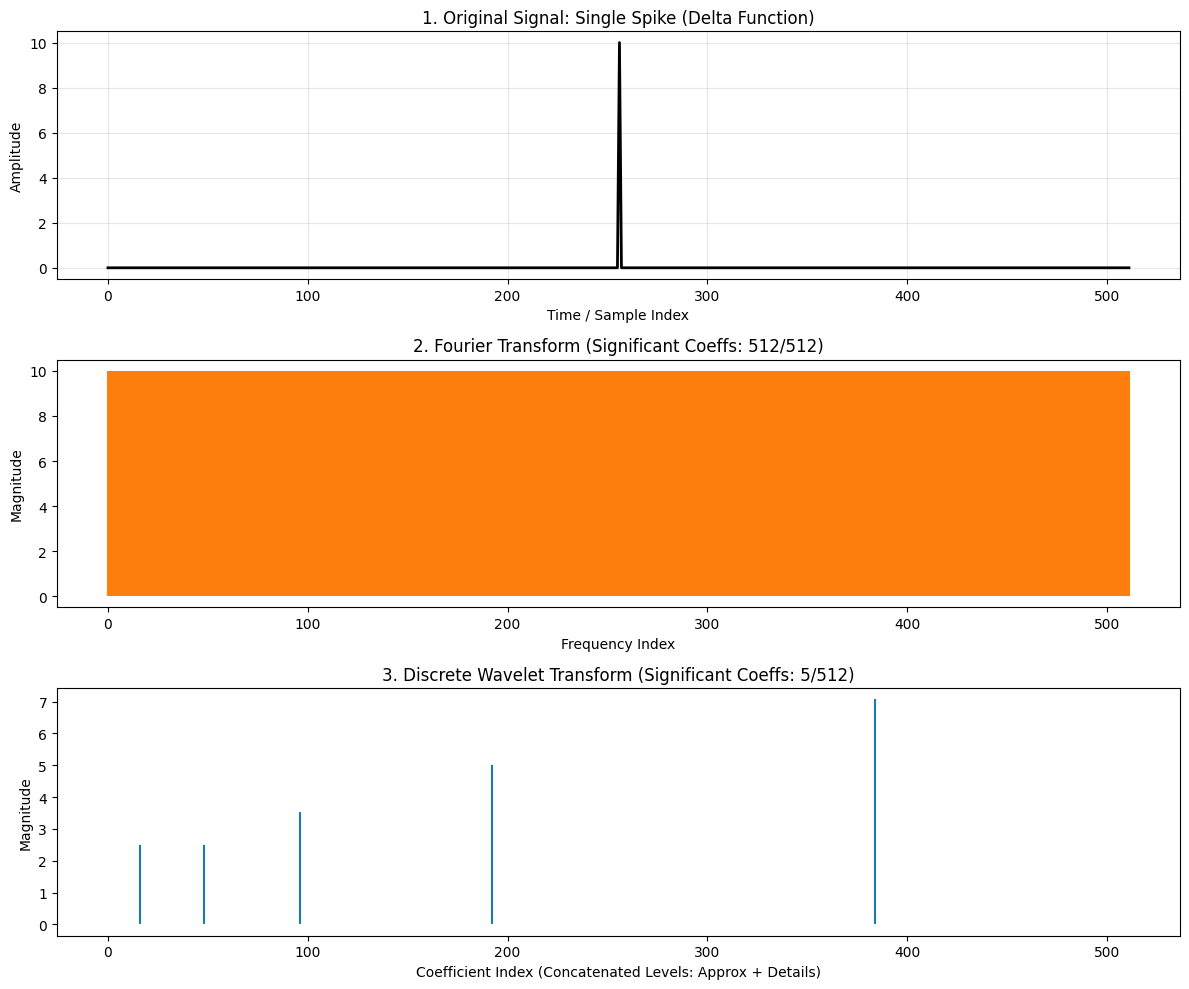

Fourier Efficiency: 100.0% coefficients used.
Wavelet Efficiency: 1.0% coefficients used.


In [4]:
# 1. Generate the signal: A single sharp spike (Delta Function)
N = 512
signal_spike = np.zeros(N)
signal_spike[N//2] = 10 

# 2. Compute Transforms
fft_coeffs = np.fft.fft(signal_spike)
# We use a multi-level decomposition to show the multi-resolution nature
wt_coeffs = pywt.wavedec(signal_spike, 'haar', level=4)
wt_coeffs_flat = np.concatenate([c.flatten() for c in wt_coeffs])

# 3. Calculate Sparsity (how many coefficients are > threshold)
thresh = 0.01
f_count = np.sum(np.abs(fft_coeffs) > thresh)
w_count = np.sum(np.abs(wt_coeffs_flat) > thresh)

# 4. Visualization
fig, ax = plt.subplots(3, 1, figsize=(12, 10))

# Plot 1: The Original Signal (Time Domain)
ax[0].plot(signal_spike, color='black', linewidth=2)
ax[0].set_title(f"1. Original Signal: Single Spike (Delta Function)")
ax[0].set_xlabel("Time / Sample Index")
ax[0].set_ylabel("Amplitude")
ax[0].grid(True, alpha=0.3)

# Plot 2: Fourier Coefficients (Frequency Domain)
ax[1].stem(np.abs(fft_coeffs), markerfmt=' ', basefmt=" ", linefmt='C1-')
ax[1].set_title(f"2. Fourier Transform (Significant Coeffs: {f_count}/{N})")
ax[1].set_xlabel("Frequency Index")
ax[1].set_ylabel("Magnitude")
ax[1].text(10, 8, "GLOBAL BASIS: One spike in time \nrequires EVERY frequency to represent it.", color='C1', fontweight='bold')

# Plot 3: Wavelet Coefficients (Wavelet/Scale Domain)
ax[2].stem(np.abs(wt_coeffs_flat), markerfmt=' ', basefmt=" ", linefmt='C0-')
ax[2].set_title(f"3. Discrete Wavelet Transform (Significant Coeffs: {w_count}/{len(wt_coeffs_flat)})")
ax[2].set_xlabel("Coefficient Index (Concatenated Levels: Approx + Details)")
ax[2].set_ylabel("Magnitude")

plt.tight_layout()
plt.show()

print(f"Fourier Efficiency: {(f_count/N)*100:.1f}% coefficients used.")
print(f"Wavelet Efficiency: {(w_count/len(wt_coeffs_flat))*100:.1f}% coefficients used.")



Why are there multiple spikes? The x-axis here is a "concatenated index." It contains the Approximation (low-res) followed by several levels of Details (high-res). Because wavelets look at the signal at multiple scales, you see a small spike at each level where the wavelet "caught" the original signal's spike.

The Power of Sparsity: Even though there are a few spikes across the different levels, the vast majority of the x-axis is zero. This Sparse Representation is the fundamental reason why wavelets are used for data compression and denoising: we can describe complex, "spiky" real-world data using only a tiny fraction of the information required by Fourier analysis.

In [5]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 100  # in MB

# Signal    
x = np.linspace(0, 1, 500)
signal = np.sin(2*np.pi*(5 + 40*x**2) * x)

# Wavelet scales (one at a time)
scales = [50, 100, 200]  # number of points in wavelet
colors = ['blue', 'red', 'green']

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(x, signal, color='black', label='Signal')
wavelet_line, = ax.plot([], [], color='blue', lw=2)
ax.set_ylim(-1.5, 1.5)
ax.set_xlim(0,1)
ax.set_title("Wavelet sliding over signal")
ax.legend(['Signal'])

# Prepare wavelets
wavelets = []
for scale in scales:
    w, x_w = pywt.ContinuousWavelet('cgau3').wavefun(length=scale)
    w = w / np.max(np.abs(w))  # normalize amplitude
    x_span = scale / len(x)  # span in x domain
    # rescale x-axis to match 0..1 domain
    x_w_scaled = x_w / (x_w.max() - x_w.min()) * x_span
    wavelets.append((w, x_w_scaled))

# Animation settings
current_scale_index = [0]  # use list to modify in animate

def init():
    wavelet_line.set_data([], [])
    return wavelet_line,

def animate(frame):
    scale_idx = current_scale_index[0]
    w, x_w = wavelets[scale_idx]
    center = x[frame_to_scale(frame)]
    shifted_x = x_w + center
    wavelet_line.set_data(shifted_x, w)
    wavelet_line.set_color(colors[scale_idx])
    return wavelet_line,

# Total frames = len(x) * number of scales
frames_per_scale = len(x)
total_frames = frames_per_scale * len(scales)

def frame_to_scale(f):
    scale_idx = f // frames_per_scale
    frame_in_scale = f % frames_per_scale
    current_scale_index[0] = scale_idx
    return frame_in_scale


ani = FuncAnimation(fig, animate, frames=total_frames,
                    init_func=init, blit=True, interval=20)

HTML(ani.to_jshtml())
# Save the animation as a GIF file (optional)
ani.save('wavelet_sliding.gif', writer='pillow', fps=30)
plt.close()

c:\Users\User\Desktop\WaveLets\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
Animation size has reached 104915282 bytes, exceeding the limit of 104857600.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.
c:\Users\User\Desktop\WaveLets\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


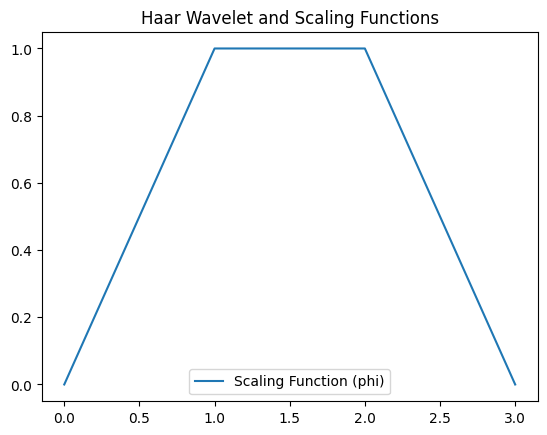

In [6]:
import pywt
import matplotlib.pyplot as plt
phi, psi,x = pywt.Wavelet('haar').wavefun(level=1)
plt.plot(phi, label='Scaling Function (phi)')
#plt.plot(psi, label='Wavelet Function (psi)')
plt.title('Haar Wavelet and Scaling Functions')
plt.legend()
plt.show()

Example 1, square wave

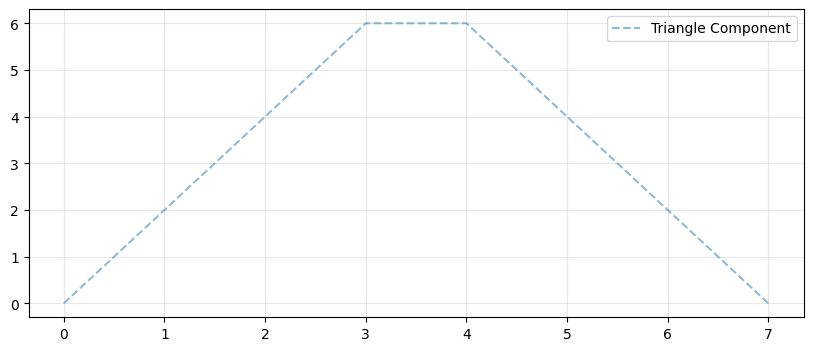

Signal Data Points: [0 2 4 6 6 4 2 0]


In [2]:
# 1. Define a Triangle Signal (Ramp up and down)
signal = np.array([0, 2, 4, 6, 6, 4, 2, 0])

# Visualization
plt.figure(figsize=(10, 4))
plt.plot(signal, '--', label='Triangle Component', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("Signal Data Points:", signal)

In [3]:
# Perform Haar decomposition
# Note: PyWavelets uses normalization (1/sqrt(2)), 
# so we divide by sqrt(2) to match our "pen and paper" integers.
cA, cD = pywt.dwt(signal, 'haar')

# To get the hand-calculation integers (un-normalized):
cA1_hand = cA * np.sqrt(2)
cD1_hand = cD * np.sqrt(2)

print(f"Original Signal: {signal}")
print(f"Approximation (Sums): {cA1_hand}")
print(f"Details (Differences): {cD1_hand}")

Original Signal: [0 2 4 6 6 4 2 0]
Approximation (Sums): [ 2. 10. 10.  2.]
Details (Differences): [-2. -2.  2.  2.]


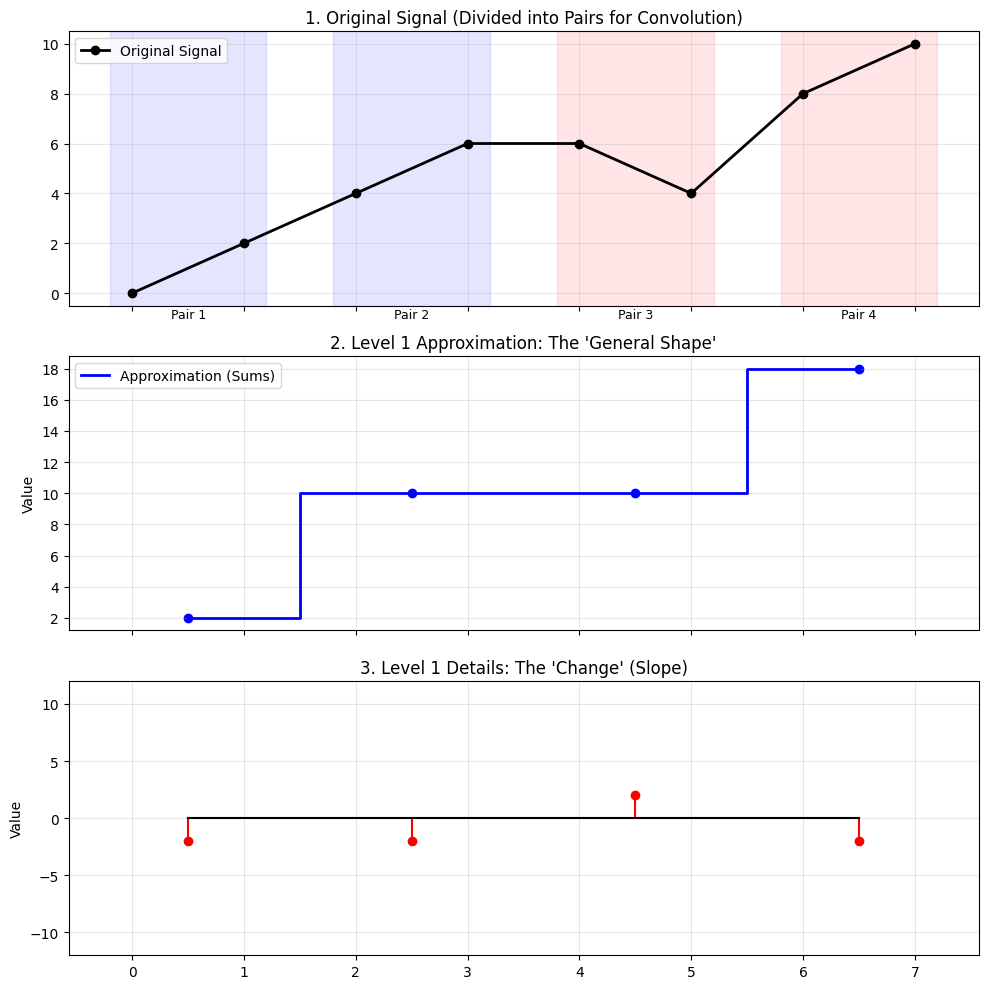

In [ ]:
signal = np.array([0, 2, 4, 6, 6, 4, 8, 10])
x = np.arange(len(signal))

# Manual Level 1 (Hand-calc integers)
cA_hand = np.array([2, 10, 10, 18])
cD_hand = np.array([-2, -2, 2, -2])
x_coeffs = np.arange(0, 8, 2) + 0.5 # Centering the 4 points over the pairs

fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# 1. Original Signal & The "Windows"
ax[0].plot(x, signal, 'ko-', label="Original Signal", linewidth=2)
for i in range(0, 8, 2):
    ax[0].axvspan(i-0.2, i+1.2, alpha=0.1, color='blue' if i<4 else 'red')
    ax[0].text(i+0.5, -1, f"Pair {i//2 + 1}", ha='center', fontsize=9)
ax[0].set_title("1. Original Signal (Divided into Pairs for Convolution)")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# 2. Level 1 Approximation (Sums)
# We use 'drawstyle=steps-mid' to show the "Square Wave" nature of the Haar approach
ax[1].step(x_coeffs, cA_hand, where='mid', color='blue', linewidth=2, label="Approximation (Sums)")
ax[1].scatter(x_coeffs, cA_hand, color='blue')
ax[1].set_title("2. Level 1 Approximation: The 'General Shape'")
ax[1].set_ylabel("Value")
ax[1].legend()
ax[1].grid(True, alpha=0.3)

# 3. Level 1 Details (Differences)
ax[2].stem(x_coeffs, cD_hand, linefmt='r-', markerfmt='ro', basefmt='k-')
ax[2].set_title("3. Level 1 Details: The 'Change' (Slope)")
ax[2].set_ylim(-12, 12) # Keeping scale consistent with Apprx for comparison
ax[2].set_ylabel("Value")
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Perform Multi-Level Decomposition (Level 2)
# 'wavedec' returns a list: [cA2, cD2, cD1]
coeffs = pywt.wavedec(signal, 'haar', level=1)
A1, c1 = coeffs

# To match our "Hand-Calculated" integers:
# Level 1 required multiplying by sqrt(2)^1
# Level 2 requires multiplying by sqrt(2)^2 = 2
#cA2_hand = cA2 * 2
A1_hand = A1 * np.sqrt(2)
c1_hand = c1 * np.sqrt(2)


print(f"Level 1 approximation (cD2):       {A1_hand}")
print(f"Level 1 Details (D1):       {c1_hand}")

coeffs_2 = pywt.wavedec(signal, 'haar', level=2)
A2, C2, C3 = coeffs_2

A2_hand = A2*2
c1_2_hand = C2*2
c2_2_hand = C3*np.sqrt(2)

print(f"Level 2 approximation (cD2):       {A2_hand}")
print(f"Level 2 Details (D1):       {c1_2_hand}")
print(f"Level 1 Details (D2):       {c2_2_hand}")



Level 1 approximation (cD2):       [ 2. 10. 10. 18.]
Level 1 Details (D1):       [-2. -2.  2. -2.]
Level 2 approximation (cD2):       [12. 28.]
Level 1 Details (D1):       [-8. -8.]
Level 2 Details (D2):       [-2. -2.  2. -2.]


Approximation (cA2): [12. 28.]
Level 2 Details (cD2): [-8. -8.]
Level 1 Details (cD1): [-2. -2.  2. -2.]


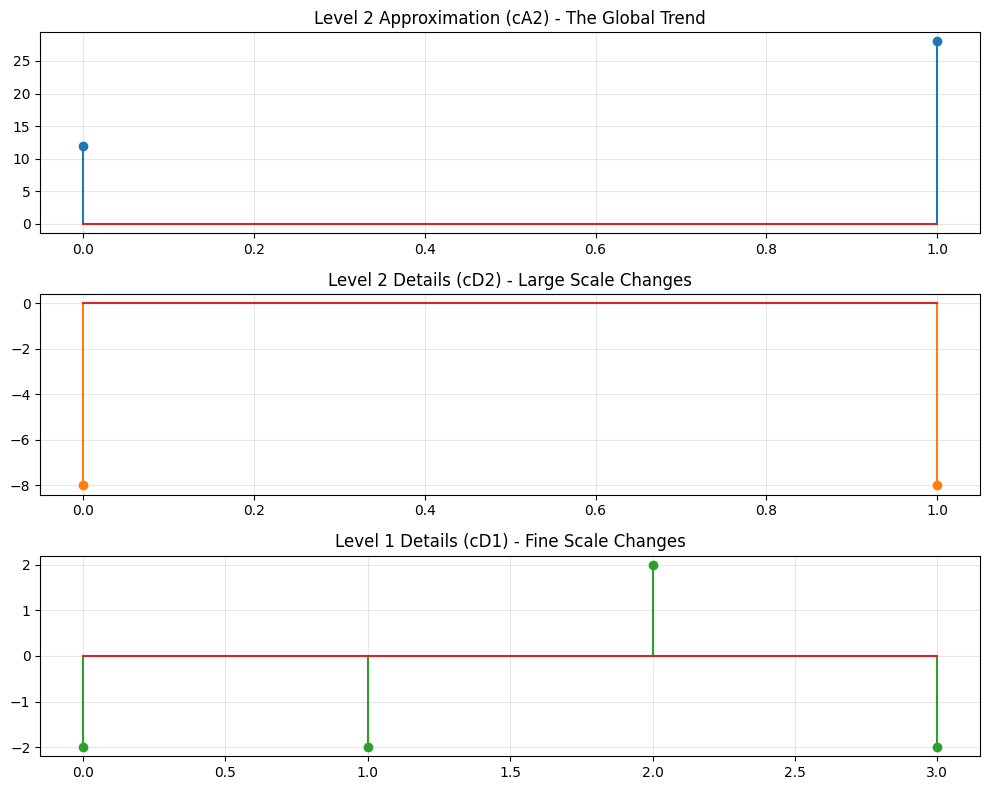

Reconstructed cA1 from L2: [ 2. 10. 10. 18.]


In [60]:
wavelet = "haar"
coeffs = pywt.wavedec(signal, wavelet, level=2)

# PyWavelets returns [cA2, cD2, cD1]
cA2 = coeffs[0]
cD2 = coeffs[1]
cD1 = coeffs[2]

# Adjusting to match your hand-calculated 'Sum/Difference' integers
# Level 2 uses sqrt(2)^2 = 2
# Level 1 uses sqrt(2)^1
cA2_hand = cA2 * 2
cD2_hand = cD2 * 2
cD1_hand = cD1 * np.sqrt(2)

print("Approximation (cA2):", cA2_hand)
print("Level 2 Details (cD2):", cD2_hand)
print("Level 1 Details (cD1):", cD1_hand)

# Plotting
plt.figure(figsize=(10, 8))

# 1. Level 2 Approximation
plt.subplot(3, 1, 1)
plt.stem(cA2_hand, linefmt='C0-', markerfmt='C0o')
plt.title('Level 2 Approximation (cA2) - The Global Trend')
plt.grid(True, alpha=0.3)

# 2. Level 2 Details
plt.subplot(3, 1, 2)
plt.stem(cD2_hand, linefmt='C1-', markerfmt='C1o')
plt.title('Level 2 Details (cD2) - Large Scale Changes')
plt.grid(True, alpha=0.3)

# 3. Level 1 Details
plt.subplot(3, 1, 3)
plt.stem(cD1_hand, linefmt='C2-', markerfmt='C2o')
plt.title('Level 1 Details (cD1) - Fine Scale Changes')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Reconstruct cA1 using the L2 coefficients
# We pass cA2 and cD2 into the inverse function
cA1_reconstructed = pywt.idwt(cA2, cD2, 'haar')

# Scale it to match your hand-calcs
cA1_hand_rec = cA1_reconstructed * np.sqrt(2)

print("Reconstructed cA1 from L2:", cA1_hand_rec)

In [61]:
# Reconstruction of the original signal by hand
# It follows as the sum and difference equations, x1 = (cA + cD)/2, x2 = (cA - cD)/2
cA1 = np.array([2, 10, 10, 18])
cD1 = np.array([-2, -2, 2, -2])

x1 = (cA1 + cD1) / 2
x2 = (cA1 - cD1) / 2
reconstructed_signal = np.empty(len(signal))
for i in range(len(cA1)):
    reconstructed_signal[2*i] = x1[i]
    reconstructed_signal[2*i + 1] = x2[i]
print("Reconstructed Signal by Hand:", reconstructed_signal)


Reconstructed Signal by Hand: [ 0.  2.  4.  6.  6.  4.  8. 10.]


Noisy Signal: [-0.20837892  1.97186659  2.93190195  6.8201354   5.10328221  3.57912632
  2.25144071 -0.62264404]


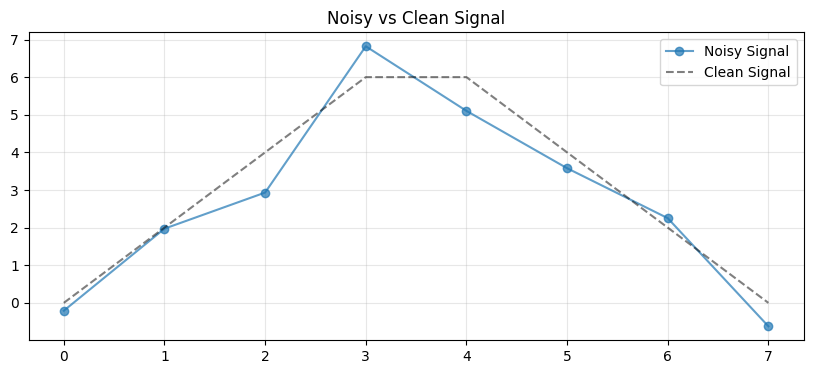

In [72]:
# Next step is denoising, well take the same signal and gaussian noise added to it

signal_clean = np.array([0, 2, 4, 6, 6, 4, 2, 0])
# Shift the signal such that index 0 is at 1
np.random.seed(2)  # For reproducibility
noise = np.random.normal(0, 0.5, signal_clean.shape)
signal_noisy = signal_clean + noise
print("Noisy Signal:", signal_noisy)

plt.figure(figsize=(10, 4))
plt.plot(signal_noisy, 'o-', label='Noisy Signal', alpha=0.7)
plt.plot(signal_clean, 'k--', label='Clean Signal', alpha=0.5)
plt.title("Noisy vs Clean Signal")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



In [74]:
coeffs_noisy = pywt.wavedec(signal_noisy, 'haar', level=2)
cA2_noisy, cD2_noisy, cD1_noisy = coeffs_noisy

print("Noisy Coefficients:")
print("cA2:", cA2_noisy*2)
print("cD2:", cD2_noisy*2)
print("cD1:", cD1_noisy*np.sqrt(2))

Noisy Coefficients:
cA2: [11.51552502 10.31120519]
cD2: [-7.98854969  7.05361186]
cD1: [-2.18024551 -3.88823345  1.52415589  2.87408475]


In [75]:
# Now you can apply thresholding to cD1_noisy and cD2_noisy to denoise the signal
threshold = 0.5
cD1_denoised = pywt.threshold(cD1_noisy, threshold, mode='hard')
cD2_denoised = pywt.threshold(cD2_noisy, threshold, mode='hard')

denoised_coeffs = [cA2_noisy, cD2_denoised, cD1_denoised]
print(f'cD1_denoised: {cD1_denoised}')
print(f'cD2_denoised: {cD2_denoised}')
print(f'cA2_noisy: {cA2_noisy}')
print(f"L1 Details after Denoising: {cD1_denoised * np.sqrt(2)}")


cD1_denoised: [-1.54166638 -2.74939624  1.07774097  2.03228482]
cD2_denoised: [-3.99427485  3.52680593]
cA2_noisy: [5.75776251 5.15560259]
L1 Details after Denoising: [-2.18024551 -3.88823345  1.52415589  2.87408475]


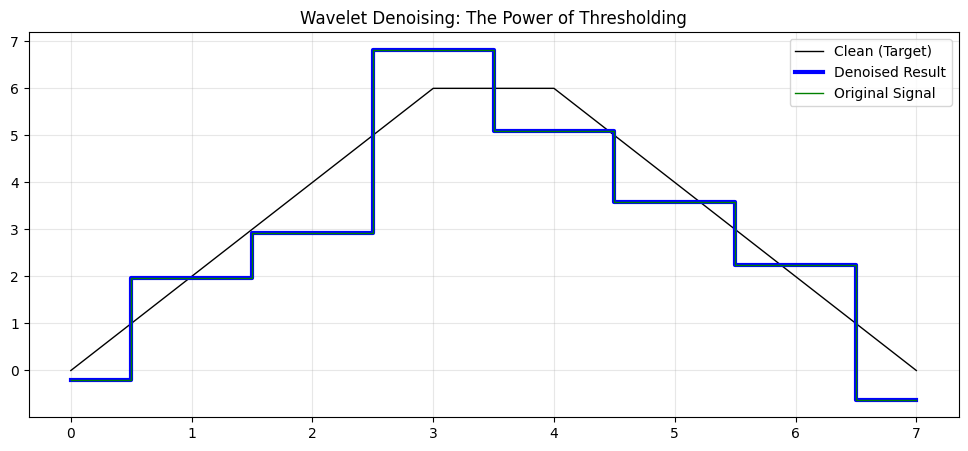

In [76]:
# We can now utilize the inverse wavelet transform to reconstruct the "cleanded" signal back into a time-series signal
# Reconstruct
signal_denoised = pywt.waverec(denoised_coeffs, 'haar')

# Plot the results side-by-side
plt.figure(figsize=(12, 5))


#plt.plot(signal_noisy, 'r--', alpha=0.5, label="Noisy Signal")
plt.plot(signal_clean, 'k-', linewidth=1, label="Clean (Target)")
plt.step(np.arange(8), signal_denoised, 'b-', where='mid', linewidth=3, label="Denoised Result")
plt.step(np.arange(8), signal_noisy, 'g-', where='mid', linewidth=1, label="Original Signal")

plt.title("Wavelet Denoising: The Power of Thresholding")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



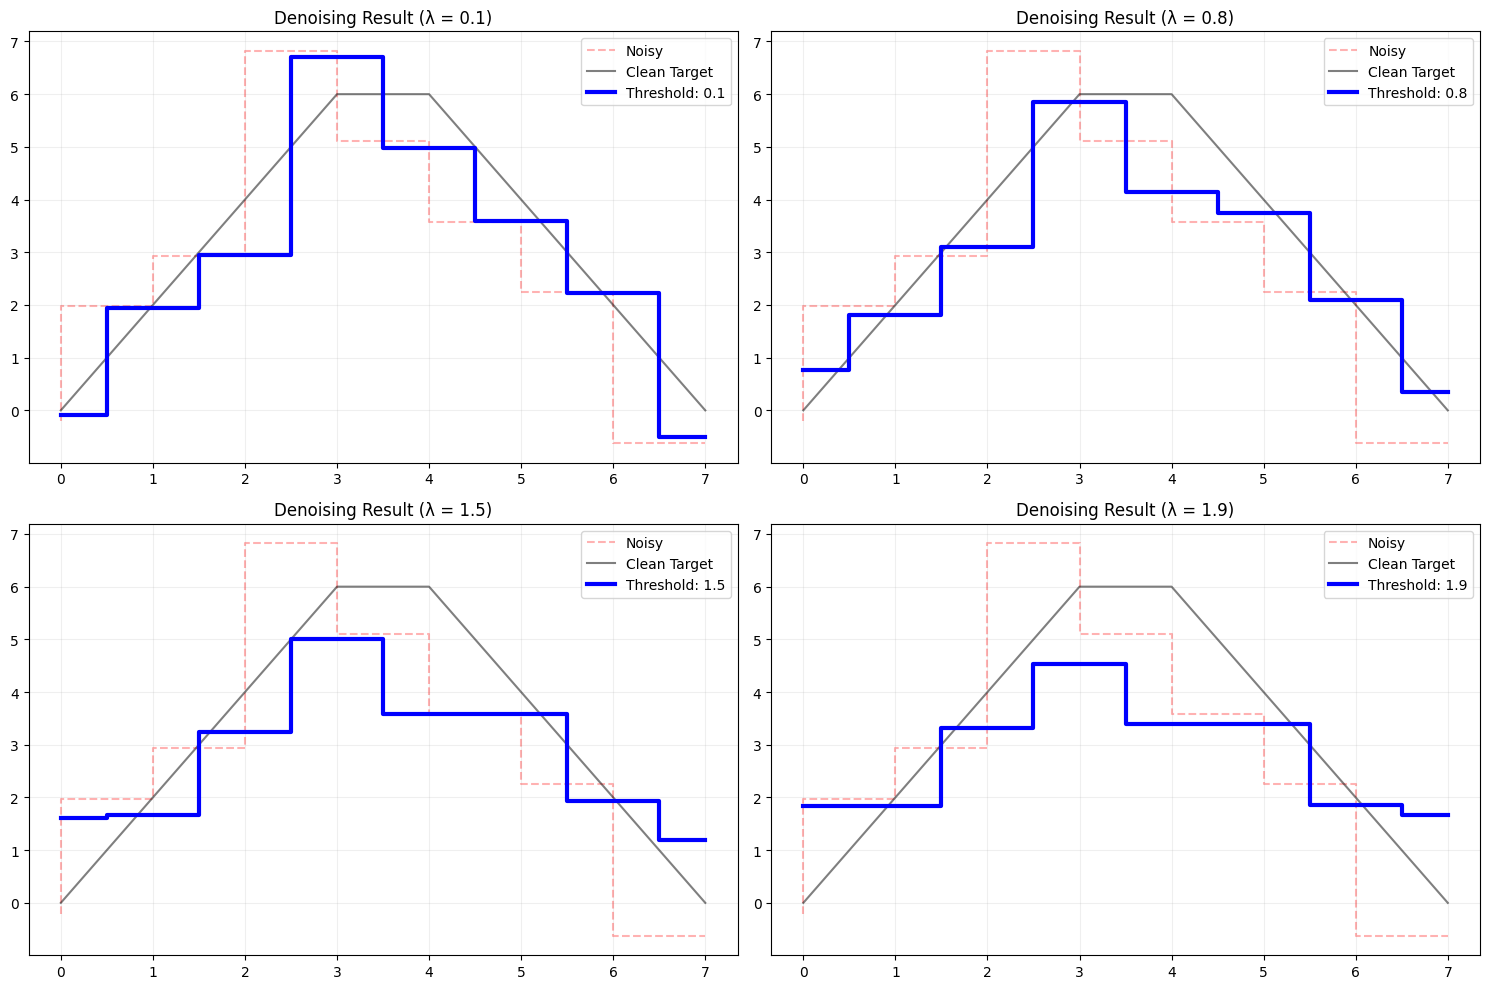

In [77]:
# 2. Decompose (Level 2 Haar)
coeffs = pywt.wavedec(signal_noisy, 'haar', level=2)
cA2, cD2, cD1 = coeffs

# 3. Define the Thresholds to test
test_thresholds = [0.1, 0.8, 1.5, 1.9]

# 4. Create the Loop for visualization
plt.figure(figsize=(15, 10))

for i, val in enumerate(test_thresholds):
    # Apply hard thresholding to both levels of details
    cD2_t = pywt.threshold(cD2, val, mode='soft')
    cD1_t = pywt.threshold(cD1, val, mode='soft')
    
    # Reconstruct
    denoised = pywt.waverec([cA2, cD2_t, cD1_t], 'haar')
    
    # Plotting
    plt.subplot(2, 2, i+1)
    #plt.plot(signal_noisy, 'r--', alpha=0.3, label="Noisy")
    plt.step(np.arange(8), signal_denoised,'r--', alpha=0.3, label="Noisy")
    plt.plot(signal_clean, 'k-', alpha=0.5, label="Clean Target")
    plt.step(np.arange(8), denoised, 'b-', where='mid', linewidth=3, label=f"Threshold: {val}")
    
    plt.title(f"Denoising Result (λ = {val})")
    plt.legend()
    plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

We will now move on to slightly more interresting case than the square wave. We will utilize a sine function as a signal with added gaussian noise.

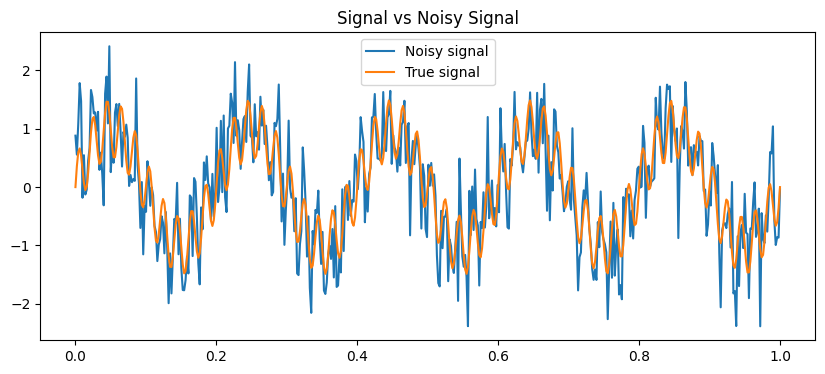

In [ ]:
np.random.seed(0)

# clean signal: slow + fast components
x = np.linspace(0, 1, 500)

signal = np.sin(2 * np.pi * 5 * x) + 0.5 * np.sin(2 * np.pi * 50 * x)

# add gaussian noise
noise = 0.5 * np.random.normal(size=x.shape)
noisy_signal = signal + noise

plt.figure(figsize=(10,4))
plt.plot(x, noisy_signal, label="Noisy signal")
plt.plot(x, signal, label="True signal")
plt.legend()
plt.title("Signal vs Noisy Signal")
plt.show()


In [ ]:
# Perform discrete wavelet transform
wavelet = "db4"   # Daubechies-4
coeffs = pywt.wavedec(noisy_signal, wavelet, level=4)

approximation = coeffs[0]
details = coeffs[1:]
len(coeffs), [len(c) for c in coeffs]

# Coeffs is a list where the first element is the approximation coefficients and the following elements are the detail coefficients at each level.
# Which are corresponding to low (approximation) and high (detail) frequency components respectively.

(5, [37, 37, 68, 130, 253])

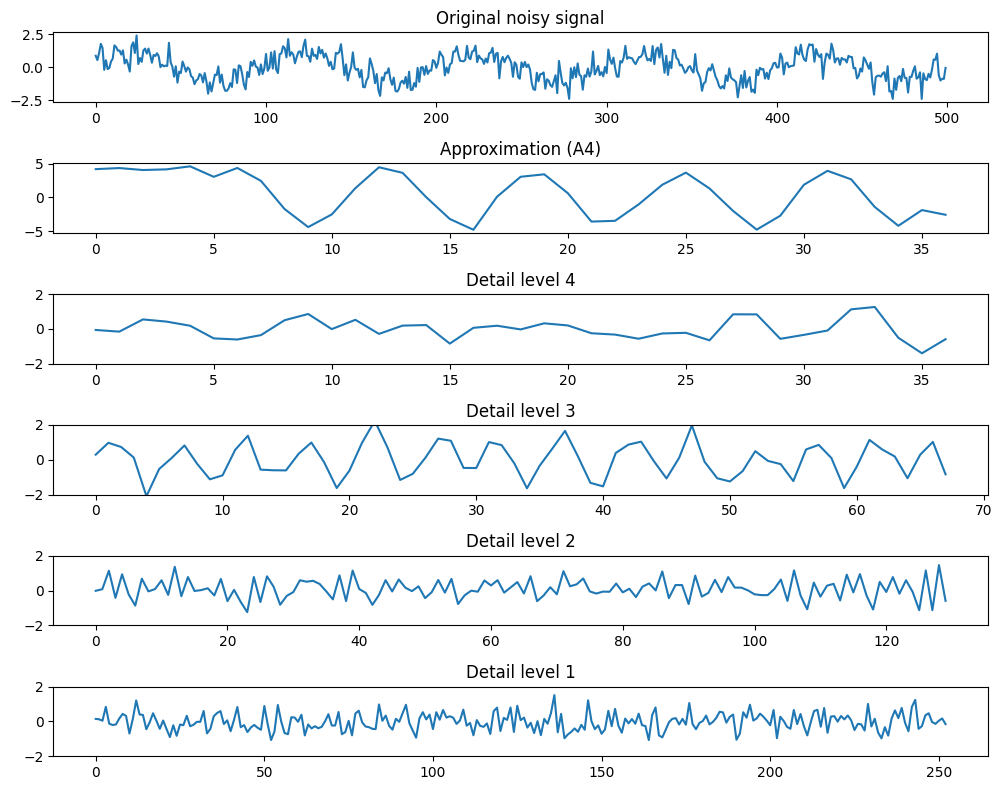

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(6,1,1)
plt.plot(noisy_signal)
plt.title("Original noisy signal")
plt.subplot(6,1,2)
plt.plot(approximation)
plt.title("Approximation (A4)")
lims = (-2, 2)
for i, d in enumerate(details, start=1):
    level = 5 - i
    plt.subplot(6,1,i+2)
    plt.plot(d)
    plt.ylim(lims)
    plt.title(f"Detail level {level}")

plt.tight_layout()
plt.show()


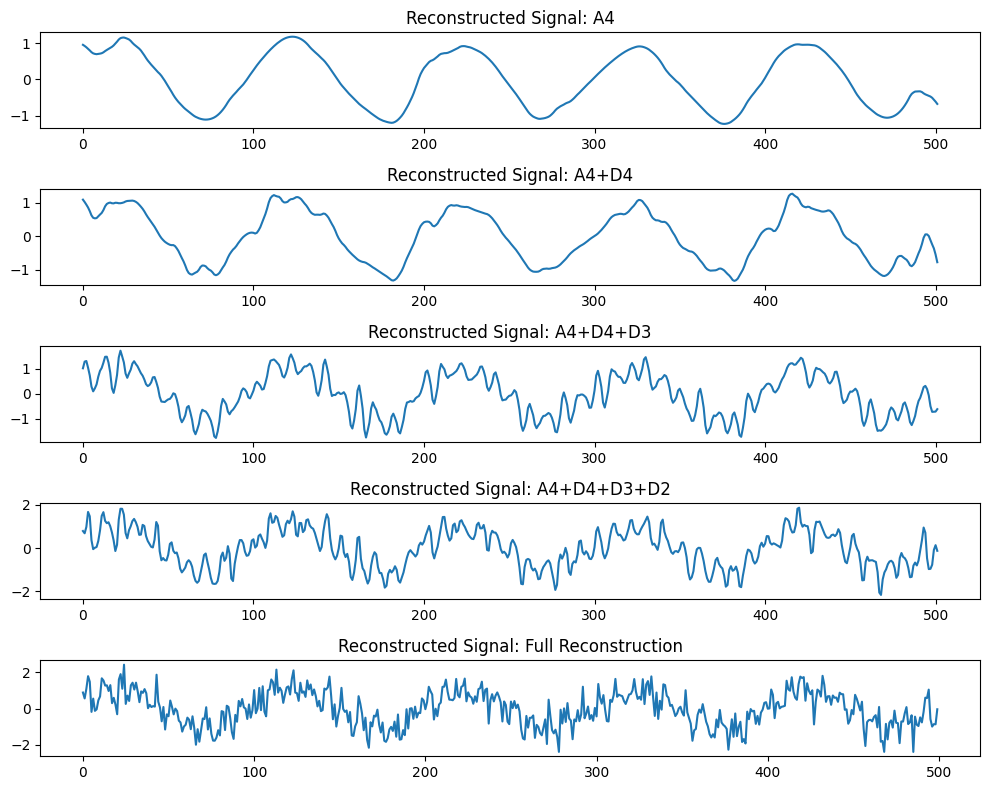

In [ ]:
# Here reconstruction of the signal from components step by step
recon_A4 = pywt.waverec([approximation, None, None, None, None], 'db4')
recon_A4_D4 = pywt.waverec([approximation, details[0], None, None, None], 'db4')
recon_A4_D4_D3 = pywt.waverec([approximation, details[0], details[1], None, None], 'db4')
recon_A4_D4_D3_D2 = pywt.waverec([approximation, details[0], details[1], details[2], None], 'db4')
reconstructed_signal = pywt.waverec(coeffs, 'db4')

signals = [recon_A4, recon_A4_D4, recon_A4_D4_D3, recon_A4_D4_D3_D2, reconstructed_signal]
labels = ['A4', 'A4+D4', 'A4+D4+D3', 'A4+D4+D3+D2', 'Full Reconstruction']

plt.figure(figsize=(10,8))
for i, (sig, label) in enumerate(zip(signals, labels), start=1):
    plt.subplot(5,1,i)
    plt.plot(sig)
    plt.title(f"Reconstructed Signal: {label}")
plt.tight_layout()
plt.show()

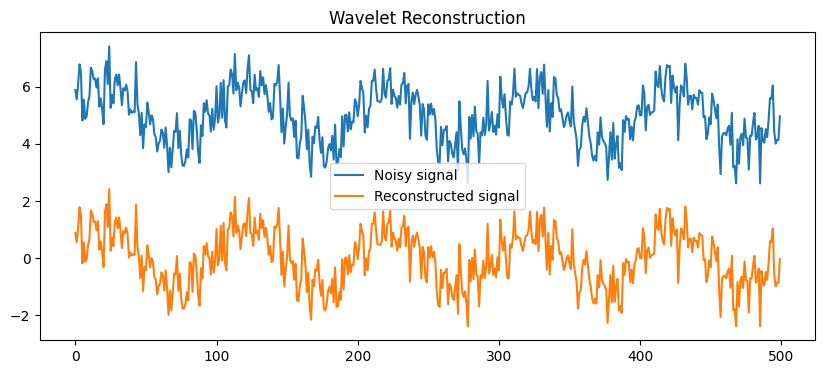

In [ ]:
# Reconstruct the signal from wavelet coefficients. This can be thought of as A1 + D1 + D2 + D3 + D4 (Approximation + Details). Which is to show that the original signal can be perfectly reconstructed from its wavelet coefficients.
reconstructed = pywt.waverec(coeffs, wavelet)

plt.figure(figsize=(10,4))
plt.plot(noisy_signal+5, label="Noisy signal") # shifted up for clarity, remove +5 to see original position
plt.plot(reconstructed, label="Reconstructed signal")
plt.legend()
plt.title("Wavelet Reconstruction")
plt.show()


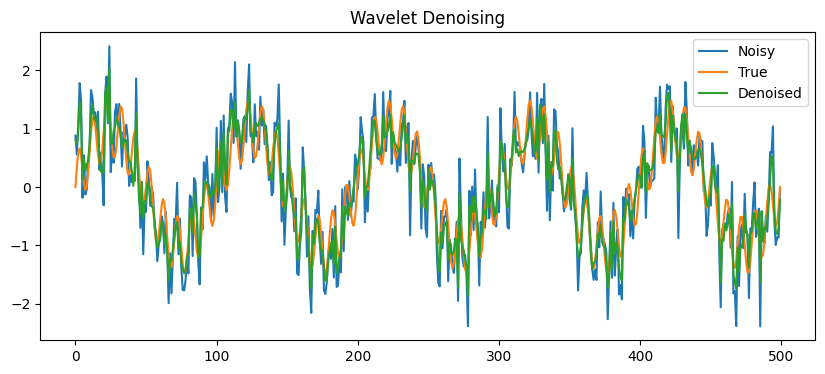

In [ ]:
# Wavelet Denoising
# A noisy signal looks like signal + noise. The noise tends to affect the high-frequency components more than the low-frequency components. 
# Therefore, by thresholding the detail coefficients (which correspond to high frequencies), we can reduce the noise while preserving the main features of the signal.

# The steps are:
# 1. Perform DWT to get wavelet coefficients.
# 2. Apply a threshold to the detail coefficients.
# 3. Reconstruct the signal using the modified coefficients.

coeffs = pywt.wavedec(noisy_signal, wavelet, level=4)
threshold = np.median(np.abs(coeffs[-1])) / 0.6745
denoised_coeffs = [coeffs[0]]  # keep approximation
for i, d in enumerate(coeffs[1:], start=1):
    # Here we use a level-dependent threshold, with the idea that finer details (higher levels) may require higher thresholds.
    level_threshold = threshold * (0.5 + 0.1*(i-1))
    denoised_coeffs.append(pywt.threshold(d, level_threshold, mode='soft'))

# The soft thresholding formula is:
# y = sign(x) * max(|x| - threshold, 0)
# This means that if the absolute value of the coefficient is less than the threshold, it is set to zero.
# If it is greater than the threshold, it is shrunk towards zero by the threshold amount
# The hard thresholding simply sets coefficients below the threshold to zero without shrinking the others.

denoised_signal = pywt.waverec(denoised_coeffs, wavelet)

plt.figure(figsize=(10,4))
plt.plot(noisy_signal, label="Noisy")
plt.plot(signal, label="True")
plt.plot(denoised_signal, label="Denoised")
plt.legend()
plt.title("Wavelet Denoising")
plt.show()

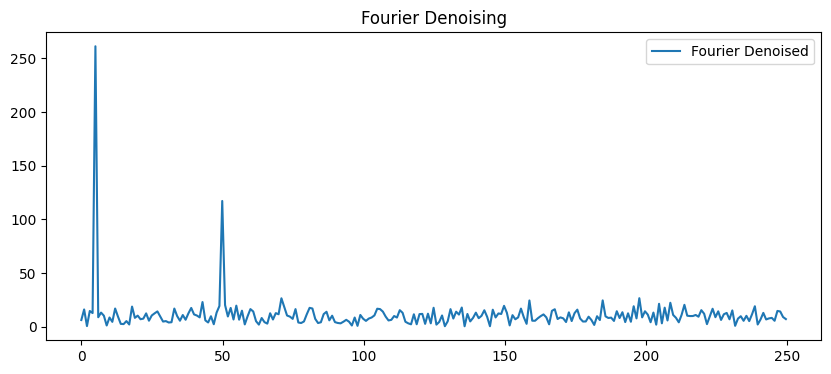

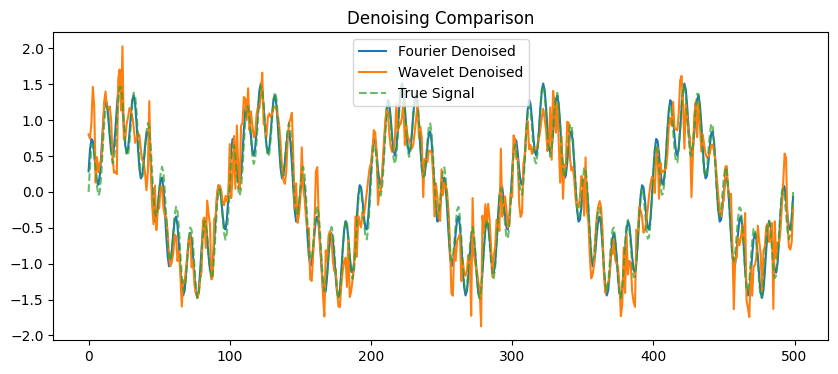

In [ ]:
# For comparison, here's a discrete Fourier transform based denoising
freqs = np.fft.rfftfreq(len(noisy_signal), d=(x[1]-x[0]))
fft_coeffs = np.fft.rfft(noisy_signal)

plt.figure(figsize=(10,4))
plt.plot(freqs, np.abs(fft_coeffs), label="Fourier Denoised")
plt.legend()
plt.title("Fourier Denoising")
plt.show()

freq_domain = np.fft.fft(noisy_signal)

# Basic fourier denoising by zeroing out small coefficients

Threshold = 0.4*np.max(np.abs(freq_domain))
filtered_frequency = np.where(np.abs(freq_domain) > Threshold, freq_domain, 0)
fourier_denoised = np.fft.ifft(filtered_frequency).real


# Plot the fourier and wavelet denoised signals together for comparison
plt.figure(figsize=(10,4))
plt.plot(fourier_denoised, label="Fourier Denoised")
plt.plot(denoised_signal, label="Wavelet Denoised")
plt.plot(signal, label="True Signal", linestyle='--', alpha=0.7)
plt.legend()
plt.title("Denoising Comparison")
plt.show()
